In [52]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5, style='whitegrid')

from mb_nas.utils.plotting import get_gaussian_region, get_lognormal_region

In [53]:
baseline_table = {
    'ResNet20': {'num_ops': 31, 'num_params': 1084586},
    'ResNet32': {'cifar10': 0.9480, 'cifar100': 0.7464, 'num_ops': 49, 'num_params': 1860522},
    'ResNet50': {'num_ops': 76, 'num_params': 3024426},
}

In [54]:
def get_arm_trials(exp_name, table_name, col_name, window=1):
    exp_path = Path('../data/experiments') / exp_name
    exp_dfs = [pd.read_csv(f) for f in exp_path.rglob(table_name)]
    assert len(exp_dfs) > 0, 'no files found'
    min_len = min([len(df) for df in exp_dfs])
    smoothed_trials = [df[col_name].rolling(window).mean() for df in exp_dfs]
    arm_trials = np.stack([trial.values[:min_len] for trial in smoothed_trials])
    return arm_trials

In [76]:
dataset = 'cifar100'
target_ratio = '.875'

arm_1_name = f'grasp_nas_{dataset}_v2.1{target_ratio}'
arm_2_name = f'random_nas_{dataset}_v1.1{target_ratio}'
arm_3_name = f'wmag_nas_{dataset}_v2.1{target_ratio}'

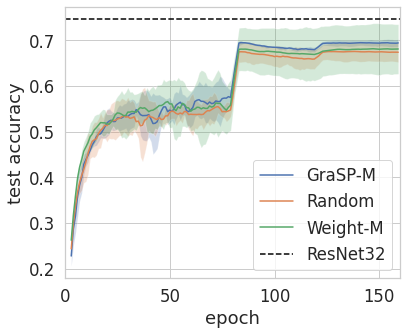

In [78]:
col_name = 'test_acc'
window = 4

arm_1_trials = get_arm_trials(arm_1_name, 'train_metrics.csv', col_name, window)
arm_1_mean = (arm_1_trials / 100).mean(0)
arm_1_var = (arm_1_trials / 100).var(0)
arm_1_mid, arm_1_lb, arm_1_ub = get_gaussian_region(arm_1_mean, arm_1_var)

arm_2_trials = get_arm_trials(arm_2_name, 'train_metrics.csv', col_name, window)
arm_2_mean = (arm_2_trials / 100).mean(0)
arm_2_var = (arm_2_trials / 100).var(0)
arm_2_mid, arm_2_lb, arm_2_ub = get_gaussian_region(arm_2_mean, arm_2_var)

arm_3_trials = get_arm_trials(arm_3_name, 'train_metrics.csv', col_name, window)
arm_3_mean = (arm_3_trials / 100).mean(0)
arm_3_var = (arm_3_trials / 100).var(0)
arm_3_mid, arm_3_lb, arm_3_ub = get_gaussian_region(arm_3_mean, arm_3_var)

fig = plt.figure(figsize=(6, 5))

xlim = plt.xlim((0, 160))
baseline_acc = baseline_table['ResNet32'][dataset]
plt.hlines(baseline_acc, *xlim, color='black', linestyle='--', label='ResNet32')

plt.plot(arm_1_mid, label='GraSP-M')
plt.fill_between(range(arm_1_mean.shape[0]), arm_1_lb, arm_1_ub, alpha=0.25)

plt.plot(arm_2_mid, label='Random')
plt.fill_between(range(arm_2_mean.shape[0]), arm_2_lb, arm_2_ub, alpha=0.25)

plt.plot(arm_3_mid, label='Weight-M')
plt.fill_between(range(arm_3_mean.shape[0]), arm_3_lb, arm_3_ub, alpha=0.25)

plt.legend(loc='lower right')
plt.ylabel('test accuracy')
plt.xlabel('epoch')
# plt.title(f'GraphNet32, {dataset.upper()}, target ratio: {target_ratio}')
plt.tight_layout()
# plt.savefig(f'figures/graphnet32{target_ratio}_pruning_comparison_{dataset}.pdf')

In [43]:
arm_1_num_params = get_arm_trials(arm_1_name, 'pruning_metrics.csv', 'num_params')
arm_1_num_params.mean(0).astype(int)

array([22604528,  2375995,  2375831])

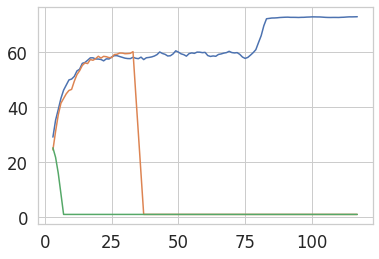

In [75]:
for trial in arm_2_trials:
    plt.plot(trial)